In [1]:
!pip install -q split-folders

In [2]:
import os
import cv2
import numpy as np
import zipfile
import splitfolders
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [4]:
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

# PREPROCESSING GAMBAR

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def contrast_stretching(img):
    # Contrast stretching per channel
    out = np.zeros_like(img)
    for i in range(img.shape[2]): 
        channel = img[:, :, i]
        min_val = np.min(channel)
        max_val = np.max(channel)
        # Stretching ke rentang [0, 255]
        stretched = ((channel - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        out[:, :, i] = stretched
    return out

def preprocess_leaf_image(image):
    # Noise reduction dengan Gaussian Blur + Median Filter (Blur ringan)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    denoised = cv2.medianBlur(blurred, 3)

    # Konversi ke LAB untuk histogram equalization pada channel L
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # CLAHE pada channel L
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Gabungkan channel LAB kembali
    limg = cv2.merge((cl, a, b))

    # Konversi ke BGR kembali
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Contrast stretching untuk memperluas rentang intensitas warna
    norm_img = contrast_stretching(final)

    return norm_img

input_root_folder = os.path.join("dataset", "dataset")
output_root_folder = "dataset_preprocessed"

os.makedirs(output_root_folder, exist_ok=True)

# Telusuri subfolder di dalam input_root_folder
for class_folder in os.listdir(input_root_folder):
    input_class_path = os.path.join(input_root_folder, class_folder)
    if not os.path.isdir(input_class_path):
        continue

    # Buat folder kelas keluaran yang sesuai
    output_class_path = os.path.join(output_root_folder, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    # Proses setiap gambar di dalam folder kelas
    for filename in tqdm(os.listdir(input_class_path), desc=f"Processing {class_folder}"):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(input_class_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Tidak bisa baca file {filename} di folder {class_folder}")
                continue

            # Preprocess
            processed_img = preprocess_leaf_image(img)

            
            save_path = os.path.join(output_class_path, filename)
            cv2.imwrite(save_path, processed_img)


Processing Common_Rust: 100%|██████████| 1306/1306 [00:10<00:00, 121.80it/s]


In [ ]:
import os
import cv2
from tqdm import tqdm
import albumentations as A

# Pipeline augmentasi
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(blur_limit=3, p=0.2),
])

input_root = "dataset_preprocessed"
output_root = "dataset_balanced_augmented"

os.makedirs(output_root, exist_ok=True)

# Menghitung jumlah sampel tiap kelas
class_counts = {}
for class_folder in os.listdir(input_root):
    class_path = os.path.join(input_root, class_folder)
    if os.path.isdir(class_path):
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        class_counts[class_folder] = len(files)

max_count = max(class_counts.values())

print("Jumlah gambar tiap kelas sebelum augmentasi balancing:")
for cls, cnt in class_counts.items():
    print(f"- {cls}: {cnt} gambar")

# Lakukan augmentasi untuk menyeimbangkan sample tiap kelas
for class_folder, count in class_counts.items():
    input_class_path = os.path.join(input_root, class_folder)
    output_class_path = os.path.join(output_root, class_folder)
    os.makedirs(output_class_path, exist_ok=True)

    # Salin gambar asli ke folder output
    for filename in os.listdir(input_class_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            src_path = os.path.join(input_class_path, filename)
            dst_path = os.path.join(output_class_path, filename)
            if not os.path.exists(dst_path):
                img = cv2.imread(src_path)
                cv2.imwrite(dst_path, img)

    # Menghitung berapa banyak augmentasi tambahan yang dibutuhkan
    augment_needed = max_count - count

    if augment_needed > 0:
        print(f"Melakukan augmentasi tambahan untuk kelas {class_folder}: {augment_needed} gambar")

        images = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
        img_index = 0

        for i in range(augment_needed):
            img_name = images[img_index % len(images)]
            img_path = os.path.join(input_class_path, img_name)
            image = cv2.imread(img_path)

            augmented = augmentation_pipeline(image=image)
            aug_img = augmented['image']

            aug_filename = f"{os.path.splitext(img_name)[0]}_bal_aug{i+1}.jpg"
            save_path = os.path.join(output_class_path, aug_filename)
            cv2.imwrite(save_path, aug_img)

            img_index += 1



/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Jumlah gambar tiap kelas sebelum augmentasi balancing:
- Blight: 1146 gambar
- Gray_Leaf_Spot: 574 gambar
- Healthy: 1162 gambar
- Common_Rust: 1306 gambar
Melakukan augmentasi tambahan untuk kelas Blight: 160 gambar
Melakukan augmentasi tambahan untuk kelas Gray_Leaf_Spot: 732 gambar
Melakukan augmentasi tambahan untuk kelas Healthy: 144 gambar


In [ ]:
# Data splitting
import shutil
import random

input_root = "dataset_balanced_augmented"
output_train = "dataset_train"
output_val = "dataset_val"
output_test = "dataset_test"

split_ratio = (0.7, 0.15, 0.15)  # train, val, test

for folder in [output_train, output_val, output_test]:
    os.makedirs(folder, exist_ok=True)

# Fungsi untuk split file list menjadi 3 subset 
def split_files(file_list, ratio):
    random.shuffle(file_list)
    total = len(file_list)
    train_end = int(total * ratio[0])
    val_end = train_end + int(total * ratio[1])
    train_files = file_list[:train_end]
    val_files = file_list[train_end:val_end]
    test_files = file_list[val_end:]
    return train_files, val_files, test_files

# Proses split setiap kelas
for class_folder in os.listdir(input_root):
    input_class_path = os.path.join(input_root, class_folder)
    if not os.path.isdir(input_class_path):
        continue

    
    train_class_path = os.path.join(output_train, class_folder)
    val_class_path = os.path.join(output_val, class_folder)
    test_class_path = os.path.join(output_test, class_folder)
    for path in [train_class_path, val_class_path, test_class_path]:
        os.makedirs(path, exist_ok=True)

    files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    # Split files
    train_files, val_files, test_files = split_files(files, split_ratio)

    # Salin file ke folder output
    for f in tqdm(train_files, desc=f"Copying train files for {class_folder}"):
        shutil.copy(os.path.join(input_class_path, f), os.path.join(train_class_path, f))
    for f in tqdm(val_files, desc=f"Copying val files for {class_folder}"):
        shutil.copy(os.path.join(input_class_path, f), os.path.join(val_class_path, f))
    for f in tqdm(test_files, desc=f"Copying test files for {class_folder}"):
        shutil.copy(os.path.join(input_class_path, f), os.path.join(test_class_path, f))


Copying test files for Common_Rust: 100%|██████████| 197/197 [00:00<00:00, 6184.48it/s]


# MODEL DENGAN MOBILENETV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Direktori dataset hasil split
train_dir = "dataset_train"
val_dir = "dataset_val"
test_dir = "dataset_test"

# Parameter input gambar
img_height, img_width = 224, 224
batch_size = 32
num_classes = len(os.listdir(train_dir))

# Data generator rescale
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load MobileNetV2 pre-trained tanpa top layer
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze base model

# Tambahkan custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Training model
epochs = 10

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
)

# Evaluasi model pada test dataset
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")


Found 3656 images belonging to 4 classes.
Found 780 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 107s 902ms/step - accuracy: 0.5936 - loss: 1.0798 - val_accuracy: 0.8821 - val_loss: 0.2826
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 109s 947ms/step - accuracy: 0.8429 - loss: 0.4212 - val_accuracy: 0.9077 - val_loss: 0.2370
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 138s 914ms/step - accuracy: 0.8746 - loss: 0.3175 - val_accuracy: 0.9205 - val_loss: 0.2154
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 103s 895ms/step - accuracy: 0.8996 - loss: 0.2641 - val_accuracy: 0.9090 - val_loss: 0.2220
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 102s 890ms/step - accuracy: 0.8911 - loss: 0.2665 - val_accuracy: 0.9269 - val_loss: 0.1987
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 103s 901ms/step - accuracy: 0.9071 - loss: 0.2319 - val_accuracy: 0.9090 - val_loss: 0.2134
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 103s 898ms/step - accuracy: 0.9070 - loss: 0.2359 - val_accuracy: 0.9256 - val_loss: 0.1916
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 144s 912ms/step - accuracy: 0.9233 -

In [ ]:
from sklearn.metrics import classification_report
# Prediksi probabilitas kelas pada data test
y_pred_prob = model.predict(test_generator)

# Ambil kelas prediksi
y_pred = np.argmax(y_pred_prob, axis=1)

# Label asli
y_true = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())


# Cetak classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 797ms/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.86      0.82      0.84       197
   Common_Rust       0.95      0.96      0.96       197
Gray_Leaf_Spot       0.85      0.87      0.86       197
       Healthy       0.99      1.00      0.99       197

      accuracy                           0.91       788
     macro avg       0.91      0.91      0.91       788
  weighted avg       0.91      0.91      0.91       788



# FINE TUNING

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Aktifkan kembali trainable base_model
base_model.trainable = True

# Membuka 10 layer terakhir
fine_tune_at = len(base_model.layers) - 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Compile ulang dengan learning rate lebih kecil 
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks dengan learning rate scheduler dan early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fine-tuning training
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop]
)

# Evaluasi model di data test setelah fine tuning
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy after fine-tuning: {test_acc:.4f}")


Epoch 11/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.9518 - loss: 0.1287 - val_accuracy: 0.9205 - val_loss: 0.2269 - learning_rate: 1.0000e-05
Epoch 12/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9524 - loss: 0.1336 - val_accuracy: 0.9256 - val_loss: 0.2143 - learning_rate: 1.0000e-05
Epoch 13/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9469 - loss: 0.1344 - val_accuracy: 0.9282 - val_loss: 0.2051 - learning_rate: 1.0000e-05
Epoch 14/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9591 - loss: 0.1202 - val_accuracy: 0.9308 - val_loss: 0.1981 - learning_rate: 1.0000e-05
Epoch 15/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9571 - loss: 0.1143 - val_accuracy: 0.9333 - val_loss: 0.1902 - learning_rate: 1.0000e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 727ms/step - accuracy: 0.8268 - loss: 0.4637

Test Accuracy after fine-tuning: 0.9086


In [26]:
# Prediksi probabilitas kelas pada data test
y_pred_prob = model.predict(test_generator)

# Ambil kelas prediksi dari probabilitas tertinggi
y_pred = np.argmax(y_pred_prob, axis=1)

# Label asli dari test_generator
y_true = test_generator.classes

# Nama kelas (label)
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 769ms/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.94      0.72      0.82       197
   Common_Rust       0.96      0.96      0.96       197
Gray_Leaf_Spot       0.78      0.95      0.86       197
       Healthy       0.98      1.00      0.99       197

      accuracy                           0.91       788
     macro avg       0.92      0.91      0.91       788
  weighted avg       0.92      0.91      0.91       788



In [27]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


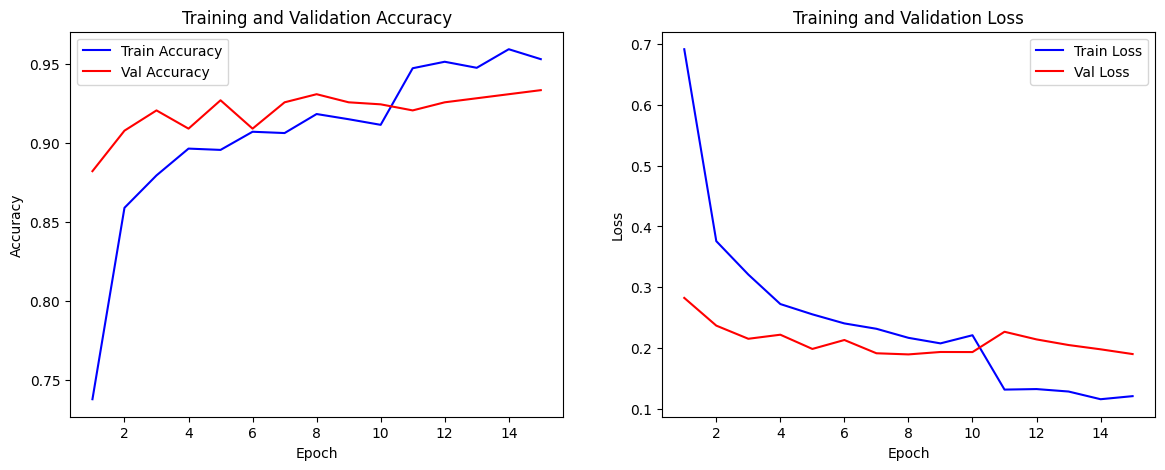

In [28]:
# Fungsi gabung history
def combine_histories(history1, history2):
    combined_history = {}
    for key in history1.history.keys():
        combined_history[key] = history1.history[key] + history2.history[key]
    return combined_history

class CombinedHistory:
    def __init__(self, history_dict):
        self.history = history_dict

combined_history_dict = combine_histories(history, history_fine)
combined_history = CombinedHistory(combined_history_dict)

# Plot
plot_training_history(combined_history)


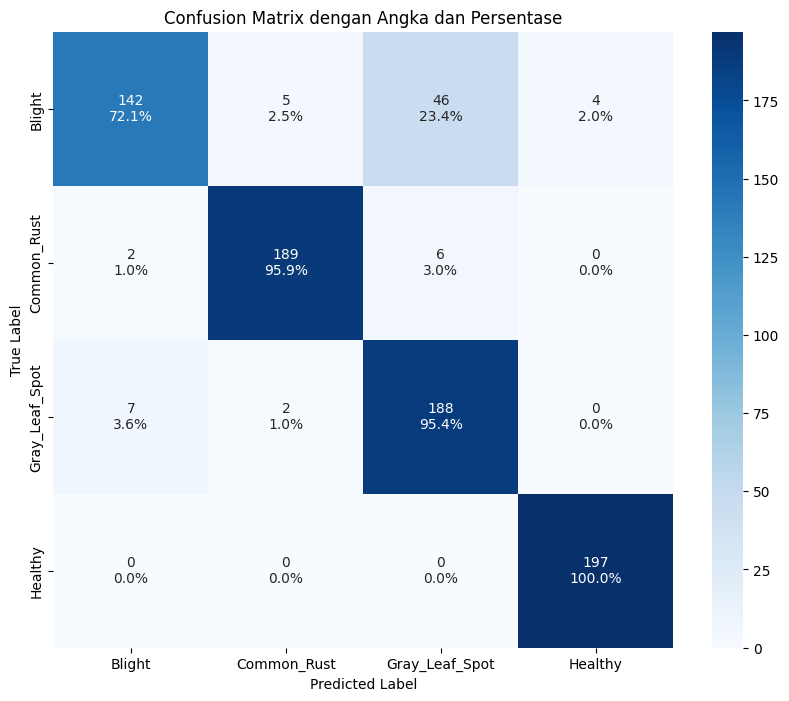

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100

    labels = np.array([f"{num}\n{perc:.1f}%" for num, perc in zip(cm.flatten(), cm_perc.flatten())])
    labels = labels.reshape(cm.shape)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix dengan Angka dan Persentase')
    plt.show()

class_labels = list(test_generator.class_indices.keys())

plot_confusion_matrix(y_true, y_pred, class_labels)
